In [1]:
import matplotlib.pyplot as plt
from scipy import stats, optimize
import json
import numpy as np

In [2]:
# open the dataset.csv file
with open('dataset.csv', 'r') as f:
    # read the file
    _ = f.read()
    # parse the data into a list of lists
    _ = [row.split(',') for row in _.split('\n')]
    # turn the list into a dictionary
    data = {}
    for row in _:
        data[row[0]] = {
            'days_taken': int(row[1]),
            'sizing': row[2],
            'number_of_tasks': int(row[3])
        }

epics = [i for i in range(len(data))]
days_taken = [row['days_taken'] for row in data.values()]
# days_taken = sorted(days_taken)

print('epic_ids:', epics)
print('days_taken:', days_taken)



epic_ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
days_taken: [421, 214, 421, 423, 451, 452, 21, 432, 654, 435, 645, 746, 546, 435, 654, 344]


Sum of residuals of the linear regression: 1890.6176470588236


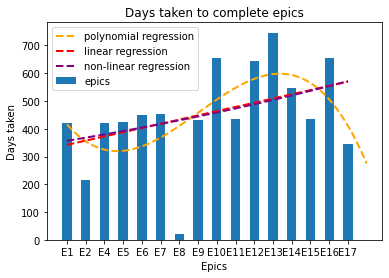

In [3]:
slope, intercept, r, p, std_err = stats.linregress(epics, days_taken)
linear_regression_line = list(map(lambda x: slope * x + intercept, epics))

print('Sum of residuals of the linear regression:', sum([abs(linear_regression_line[i] - days_taken[i]) for i in range(len(days_taken))]))

non_linear_regression_line = optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  epics,  days_taken,  p0=(4, 0.1))

mymodel = np.poly1d(np.polyfit(epics, days_taken, 3))
myline = np.linspace(0, 16, 100)

plt.plot(myline, mymodel(myline) , color='orange', linewidth=2, label='polynomial regression', linestyle='dashed')
plt.bar(epics, days_taken,  width=0.5, label='epics')

# smooth the bar graph
# plt.plot(epics, days_taken, linewidth=1, label='epics')


plt.plot(epics, linear_regression_line, color='red', linewidth=2, label='linear regression', linestyle='dashed')
plt.plot(epics, non_linear_regression_line[0][0] * np.exp(non_linear_regression_line[0][1] * np.array(epics)), color='purple', linewidth=2, label='non-linear regression', linestyle='dashed')

plt.title('Days taken to complete epics')
plt.xlabel('Epics')
plt.ylabel('Days taken')

#relabel the x axis to show the epic ids
plt.xticks(epics, [i for i in data.keys()])

plt.legend()
plt.show() 


In [4]:
# calculate the average days taken to complete an epic i.e. mean
average_days_taken = sum(days_taken) / len(days_taken)

# calculate the standard deviation of the days taken to complete an epic
standard_deviation = np.std(days_taken)

p_value = 0.1
z_value = np.abs(stats.norm.ppf(p_value))
print('z_value:', z_value)
confidence_interval = z_value * (standard_deviation / np.sqrt(len(days_taken)))

# calculate the upper and lower bounds of the confidence interval
lower_bound = average_days_taken - confidence_interval
upper_bound = average_days_taken + confidence_interval

# calc average days taken to 2 decimal places
print('average_days_taken:', round(average_days_taken))
print('standard_deviation:', standard_deviation)
print('confidence_interval:', confidence_interval)
print('lower_bound:', round(lower_bound))
print('upper_bound:', round(upper_bound))



z_value: 1.2815515655446004
average_days_taken: 456
standard_deviation: 171.70100283632593
confidence_interval: 55.01092224761784
lower_bound: 401
upper_bound: 511


c:\Users\Aman\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\Aman\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\Aman\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


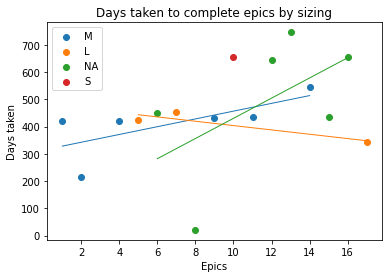

In [5]:
# cluster points into sizing groups and plot them
sizing_groups = {}
for epic, row in data.items():
    if row['sizing'] not in sizing_groups:
        sizing_groups[row['sizing']] = {
            'epics': [],
            'days_taken': []
        }
    sizing_groups[row['sizing']]['epics'].append(epic)
    sizing_groups[row['sizing']]['days_taken'].append(row['days_taken'])

for sizing, group in sizing_groups.items():
    sized_epics = [int(i.replace('E','')) for i in group['epics']]
    try:
        slope, intercept, r, p, std_err = stats.linregress(sized_epics, group['days_taken'])
        linear_regression_line = list(map(lambda x: slope * x + intercept, sized_epics))
        plt.plot(sized_epics, linear_regression_line, linewidth=1, label=sizing, linestyle='solid')
    except RuntimeWarning:
        pass
    finally:
        plt.scatter(sized_epics, group['days_taken'], label=sizing)


plt.title('Days taken to complete epics by sizing')
plt.xlabel('Epics')
plt.ylabel('Days taken')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# make the graph use 1,2,3,4,... for the x axis 
# plt.xticks(np.arange(min(epics)+1, max(epics)+1, 1.0))
plt.show()

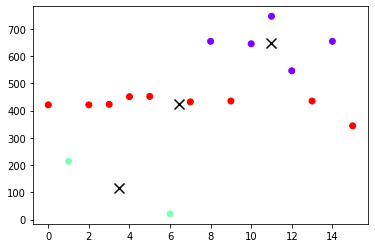

In [6]:
from sklearn.cluster import KMeans

d = list(zip(epics, days_taken))
kmeans = KMeans(
    n_clusters=3, 
    n_init=100,
    random_state=0
    ).fit(d)

plt.scatter(epics, days_taken, c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black', marker='x', s=100, label='centroids')
# color the regions of the graph based on the cluster they belong to


plt.show()


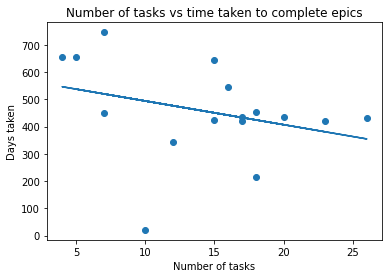

In [7]:
# compare the number of tasks in each epic to the number of days taken to complete it
number_of_tasks = [row['number_of_tasks'] for row in data.values()]

slope, intercept, r, p, std_err = stats.linregress(number_of_tasks, days_taken)
linear_regression_line = list(map(lambda x: slope * x + intercept, number_of_tasks))

plt.scatter(number_of_tasks, days_taken)
plt.plot(number_of_tasks, linear_regression_line, label='linear regression')

plt.title('Number of tasks vs time taken to complete epics')
plt.xlabel('Number of tasks')
plt.ylabel('Days taken')

plt.show()


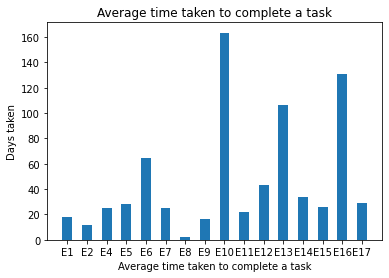

[18.304347826086957, 11.88888888888889, 24.764705882352942, 28.2, 64.42857142857143, 25.11111111111111, 2.1, 16.615384615384617, 163.5, 21.75, 43.0, 106.57142857142857, 34.125, 25.58823529411765, 130.8, 28.666666666666668]


In [8]:
# calculate average time it takes to complete a single task in an epic
averages = []
for epic, row in data.items():
    averages.append(row['days_taken'] / row['number_of_tasks'])

# create a bar graph to show the average time it takes to complete a single task in an epic
plt.bar(data.keys(), averages, width=0.5, label='epics')

plt.title('Average time taken to complete a task')
plt.xlabel('Average time taken to complete a task')
plt.ylabel('Days taken')

plt.show()

print(averages)

In [9]:
whole_numbers = lambda x: round(x, 2)

print('---- Summary of Epics ----')
print('Average time taken to complete an epic is', whole_numbers(average_days_taken), 'days')
print('The 80% confidence interval is', whole_numbers(lower_bound), 'days to', whole_numbers(upper_bound), 'days')

print('Average number of tasks in an epic is', whole_numbers(sum(number_of_tasks) / len(number_of_tasks)))
print('Average time taken to complete a single task (averaging per epic) is', whole_numbers(sum(averages) / len(averages)), 'days')

print('Shortest epic took', whole_numbers(min(days_taken)), 'days to complete')
print('Longest epic took', whole_numbers(max(days_taken)), 'days to complete')

print('Shortest task took', whole_numbers(min(averages)), 'days to complete')
print('Longest task took', whole_numbers(max(averages)), 'days to complete')

---- Summary of Epics ----
Average time taken to complete an epic is 455.88 days
The 80% confidence interval is 400.86 days to 510.89 days
Average number of tasks in an epic is 14.38
Average time taken to complete a single task (averaging per epic) is 46.59 days
Shortest epic took 21 days to complete
Longest epic took 746 days to complete
Shortest task took 2.1 days to complete
Longest task took 163.5 days to complete
